# Financial Management : 10K Documents NLP

Steps:
- Scraping
- Data Cleaning
- Preprocessing 
- data Analysis
- Calculating Cosine and Jaccard Similarity
- Computing the Sentiment of Document

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

    100% |████████████████████████████████| 18.9MB 2.0MB/s eta 0:00:01   28% |█████████                       | 5.4MB 24.7MB/s eta 0:00:01    49% |███████████████▊                | 9.3MB 26.2MB/s eta 0:00:01    89% |████████████████████████████▌   | 16.8MB 26.2MB/s eta 0:00:01
    100% |████████████████████████████████| 1.4MB 8.5MB/s eta 0:00:01   9% |███                             | 133kB 22.1MB/s eta 0:00:01
    100% |████████████████████████████████| 17.0MB 2.2MB/s eta 0:00:01  8% |██▉                             | 1.5MB 19.0MB/s eta 0:00:01    29% |█████████▋                      | 5.1MB 24.9MB/s eta 0:00:01    43% |█████████████▉                  | 7.4MB 22.6MB/s eta 0:00:01    70% |██████████████████████▌         | 11.9MB 18.6MB/s eta 0:00:01    76% |████████████████████████▋       | 13.0MB 23.9MB/s eta 0:00:01    96% |███████████████████████████████ | 16.5MB 25.0MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 13.3MB/s ta 0:00:01
  Running setup.py bdist_wheel 

      Successfully uninstalled tqdm-4.11.2


### Load Packages

In [2]:
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
import project_helper
import project_tests

from tqdm import tqdm

### Download NLP Corpus

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Getting 10k documents


In [4]:
cik_lookup = {
    'AMZN': '0001018724',
    'BMY': '0000014272',   
    'CNP': '0001130310',
    'CVX': '0000093410',
    'FL': '0000850209',
    'FRT': '0000034903',
    'HON': '0000773840'}

additional_cik = {
    'AEP': '0000004904',
    'AXP': '0000004962',
    'BA': '0000012927', 
    'BK': '0001390777',
    'CAT': '0000018230',
    'DE': '0000315189',
    'DIS': '0001001039',
    'DTE': '0000936340',
    'ED': '0001047862',
    'EMR': '0000032604',
    'ETN': '0001551182',
    'GE': '0000040545',
    'IBM': '0000051143',
    'IP': '0000051434',
    'JNJ': '0000200406',
    'KO': '0000021344',
    'LLY': '0000059478',
    'MCD': '0000063908',
    'MO': '0000764180',
    'MRK': '0000310158',
    'MRO': '0000101778',
    'PCG': '0001004980',
    'PEP': '0000077476',
    'PFE': '0000078003',
    'PG': '0000080424',
    'PNR': '0000077360',
    'SYY': '0000096021',
    'TXN': '0000097476',
    'UTX': '0000101829',
    'WFC': '0000072971',
    'WMT': '0000104169',
    'WY': '0000106535',
    'XOM': '0000034088'}

### Get list of 10-ks


In [5]:
sec_api = project_helper.SecAPI()

Pulling a list of filled 10-ks from the SEC for each company.

In [15]:
from bs4 import BeautifulSoup

def get_sec_data(cik, doc_type, start=0, count=60):
    newest_pricing_data = pd.to_datetime('2018-01-01')
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    if "Request Rate Threshold Exceeded" in sec_data:
        raise Exception("Request Rate Threshold Exceeded")
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)
        if pd.to_datetime(entry.content.find('filing-date').getText()) <= newest_pricing_data]

    return entries

In [16]:
import time

def get_sec_data_with_retries(cik, doc_type):
    print("Getting XML for ticker: " + ticker)
    try:
        return get_sec_data(cik, doc_type)
    except:
        print("Error:", sys.exc_info())
        print("Waiting 15 sec")
        time.sleep(15)
        return get_sec_data_with_retries(cik, doc_type)

Let's pull the list using the `get_sec_data` function, then display some of the results. For displaying some of the data, we'll use Amazon as an example. 

In [17]:
!export LANG="en_US.UTF-8"

example_ticker = 'AMZN'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data_with_retries(cik, '10-K')

pprint.pprint(sec_data[example_ticker][:5])

Getting XML for ticker: AMZN
Error: (<class 'Exception'>, Exception('Request Rate Threshold Exceeded',), <traceback object at 0x7f0ff0ba3888>)
Waiting 15 sec
Getting XML for ticker: AMZN
Getting XML for ticker: BMY
Getting XML for ticker: CNP
Getting XML for ticker: CVX
Getting XML for ticker: FL
Error: (<class 'Exception'>, Exception('Request Rate Threshold Exceeded',), <traceback object at 0x7f0ff0b014c8>)
Waiting 15 sec
Getting XML for ticker: FL
Getting XML for ticker: FRT
Getting XML for ticker: HON
[('https://www.sec.gov/Archives/edgar/data/1018724/000101872417000011/0001018724-17-000011-index.htm',
  '10-K',
  '2017-02-10'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872416000172/0001018724-16-000172-index.htm',
  '10-K',
  '2016-01-29'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872415000006/0001018724-15-000006-index.htm',
  '10-K',
  '2015-01-30'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872414000006/0001018724-14-000006-index.htm

### Download 10-ks


In [18]:
raw_fillings_by_ticker = {}

for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-K'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)


print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0001018724-17-000011.txt : 20170210
<SEC-HEADER>0001018724-17-000011.hdr.sgml : 20170210
<ACCEPTANCE-DATETIME>20170209175636
ACCESSION NUMBER:		0001018724-17-000011
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		92
CONFORMED PERIOD OF REPORT:	20161231
FILED AS OF DATE:		20170210
DATE AS OF CHANGE:		20170209

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			AMAZON COM INC
		CENTRAL INDEX KEY:			0001018724
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]
		IRS NUMBER:				911646860
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	000-22513
		FILM NUMBER:		17588807

	BUSINESS ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
		BUSINESS PHONE:		2062661000

	MAIL ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
</SEC-HEADER>
<DOCUMENT>
<TYPE>10-K
<S

### Get Documents
With theses fillings downloaded, we want to break them into their associated documents. These documents are sectioned off in the fillings with the tags `<DOCUMENT>` for the start of each document and `</DOCUMENT>` for the end of each document. 


In [23]:
import re


def get_documents(text):
    #TODO: Implement
    
    fillings_array = []
    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
    doc_start_is = [x.end() for x in doc_start_pattern.finditer(text)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(text)]
    
    for doc_start_i, doc_end_i in zip(doc_start_is, doc_end_is):
        fillings_array.append(text[doc_start_i:doc_end_i])
    
    return fillings_array


project_tests.test_get_documents(get_documents)

Tests Passed


With the `get_documents` function implemented, let's extract all the documents.

In [24]:
filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from HON Fillings: 100%|██████████| 20/20 [00:00<00:00, 36.33filling/s]

Document 0 Filed on 2017-02-10:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>amzn-20161231x10k.htm
<DESCRIPTION>FORM 10-K
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
	<he...

Document 1 Filed on 2017-02-10:

<TYPE>EX-12.1
<SEQUENCE>2
<FILENAME>amzn-20161231xex121.htm
<DESCRIPTION>COMPUTATION OF RATIO OF EARNINGS TO FIXED CHARGES
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http:...

Document 2 Filed on 2017-02-10:

<TYPE>EX-21.1
<SEQUENCE>3
<FILENAME>amzn-20161231xex211.htm
<DESCRIPTION>LIST OF SIGNIFICANT SUBSIDIARIES
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/h...


### Get Document Types
We want to find the 10-k form in this 10-k filing. 

In [27]:
def get_document_type(doc):
    # TODO: Implement
    
    type_pattern = re.compile(r'<TYPE>[^\n]+')
    doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(doc)]
    doc_type = doc_types[0].lower()
        
    return doc_type


project_tests.test_get_document_type(get_document_type)

Tests Passed


With the `get_document_type` function, we'll filter out all non 10-k documents.

In [28]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['cik', 'file', 'file_date'])

[
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2016123...
    file_date: '2017-02-10'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2015123...
    file_date: '2016-01-29'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2014123...
    file_date: '2015-01-30'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2013123...
    file_date: '2014-01-31'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>d445434d10k....
    file_date: '2013-01-30'},
]


## Preprocess the Data
### Clean Up


In [29]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text

Using the `clean_text` function, we'll clean up all the documents.

In [30]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_clean'])

Cleaning HON 10-Ks: 100%|██████████| 12/12 [00:31<00:00,  2.63s/10-K]

[
  {
    file_clean: '\n10-k\n1\namzn-20161231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20151231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20141231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20131231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\nd445434d10k.htm\nform 10-k\n\n\nform 1...},
]


### Lemmatize
With the text cleaned up, it's time to distill the verbs down. Implement the `lemmatize_words` function to lemmatize verbs in the list of words provided.

In [32]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):
    
    lemmed = [WordNetLemmatizer().lemmatize(w, pos='v') for w in words]
    
    return lemmed


Tests Passed


With the `lemmatize_words` function implemented, let's lemmatize all the data.

In [33]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

Lemmatize HON 10-Ks: 100%|██████████| 12/12 [00:03<00:00,  3.7710-K/s]

[
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20161231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20151231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20141231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20131231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'd445434d10k', 'htm', 'form', '1...},
]


### Remove Stopwords

In [34]:
from nltk.corpus import stopwords


lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]


print('Stop Words Removed')

Remove Stop Words for HON 10-Ks: 100%|██████████| 12/12 [00:01<00:00,  8.7810-K/s]

Stop Words Removed


## Analysis on 10ks
### Loughran McDonald Sentiment Word Lists
- Negative 
- Positive
- Uncertainty
- Litigious
- Constraining
- Interesting


In [35]:
import os


sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df = pd.read_csv(os.path.join('..', '..', 'data', 'project_5_loughran_mcdonald', 'loughran_mcdonald_master_dic_2016.csv'))
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')


sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


### Bag of Words
using the sentiment word lists, generating sentiment bag of words from the 10-k documents.

In [38]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_bag_of_words(sentiment_words, docs):
    # TODO: Implement
    return CountVectorizer(vocabulary=sentiment_words).fit_transform(docs).toarray()
    

Tests Passed


Using the `get_bag_of_words` function, we'll generate a bag of words for all the documents.

In [39]:
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}


project_helper.print_ten_k_data([sentiment_bow_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0 0 0 ..., 0 0 0]\n [0 0 0 ..., 0 0 0]\n [0 0 0...
    positive: '[[16  0  0 ...,  0  0  0]\n [16  0  0 ...,  0  0 ...
    uncertainty: '[[0 0 0 ..., 1 1 3]\n [0 0 0 ..., 1 1 3]\n [0 0 0...
    litigious: '[[0 0 0 ..., 0 0 0]\n [0 0 0 ..., 0 0 0]\n [0 0 0...
    constraining: '[[0 0 0 ..., 0 0 2]\n [0 0 0 ..., 0 0 2]\n [0 0 0...
    interesting: '[[  2   0   0   0   6   0   0   0   0   0   0   2...},
]


### Jaccard Similarity
Using the bag of words, let's calculate the jaccard similarity on the bag of words and plot it over time. 

In [42]:
from sklearn.metrics import jaccard_similarity_score


def get_jaccard_similarity(bag_of_words_matrix):

    bow = bag_of_words_matrix.astype(bool)
    sim_jac = [jaccard_similarity_score(u,v) for u,v in zip(bow, bow[1:])]
    
    return sim_jac


Tests Passed


### Plotting Jaccard Similarity


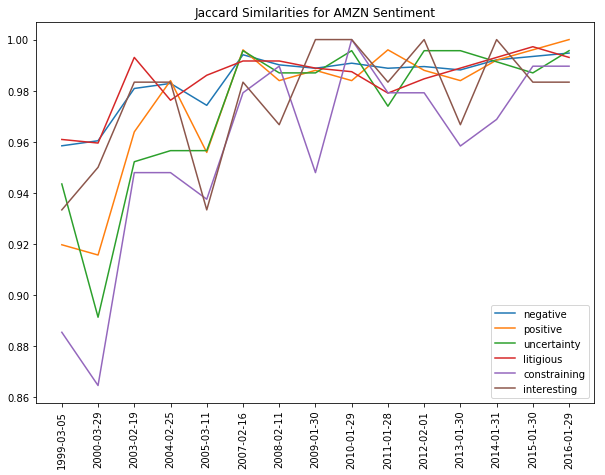

In [43]:
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}

project_helper.plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

### TFIDF
using the sentiment word lists, generating sentiment TFIDF from the 10-k documents.

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_words, docs):

    return TfidfVectorizer(vocabulary=sentiment_words).fit_transform(docs).toarray()


Tests Passed


Using the `get_tfidf` function, let's generate the TFIDF values for all the documents.

In [45]:
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

    
project_helper.print_ten_k_data([sentiment_tfidf_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[ 0.        0.        0.       ...,  0.        0...
    positive: '[[ 0.22303644  0.          0.         ...,  0.   ...
    uncertainty: '[[ 0.          0.          0.         ...,  0.005...
    litigious: '[[ 0.  0.  0. ...,  0.  0.  0.]\n [ 0.  0.  0. .....
    constraining: '[[ 0.          0.          0.         ...,  0.   ...
    interesting: '[[ 0.01673777  0.          0.          0.        ...},
]


### Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time.

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(tfidf_matrix):

    return list(cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])[0])


Tests Passed


## plot the cosine similarities over time.

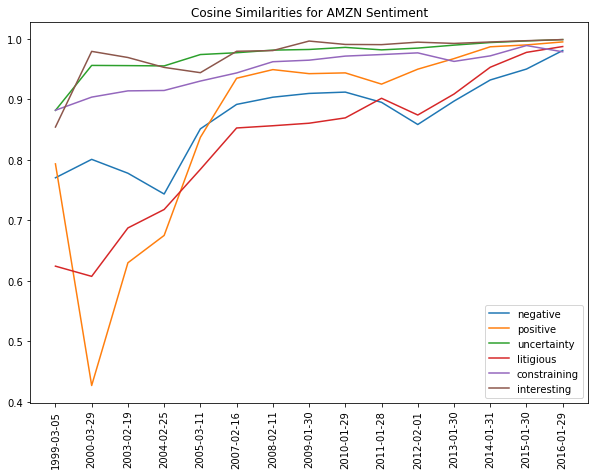

In [48]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


project_helper.plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

## WordCloud for the given 10K document

The wordCloud helps us visualize some of the most frequently used words in the document.

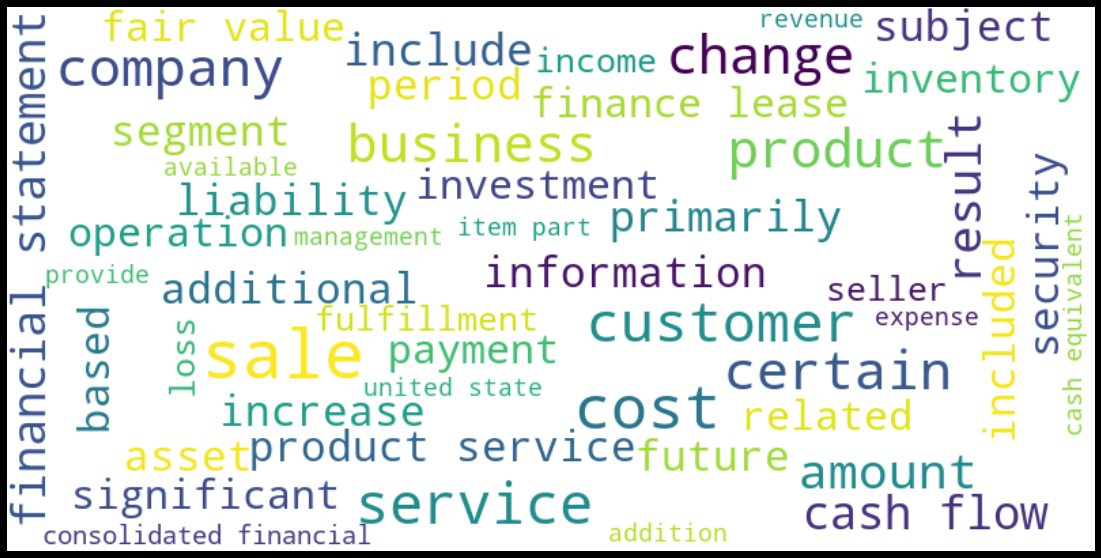

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", width=800, height=400).generate(" ".join(docs[list(docs.keys())[0]])) #first documents tokens from docs(which contains many tokens from different docs)

# Display the generated image:
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Top 20 used words in the 10K report

<AxesSubplot:>

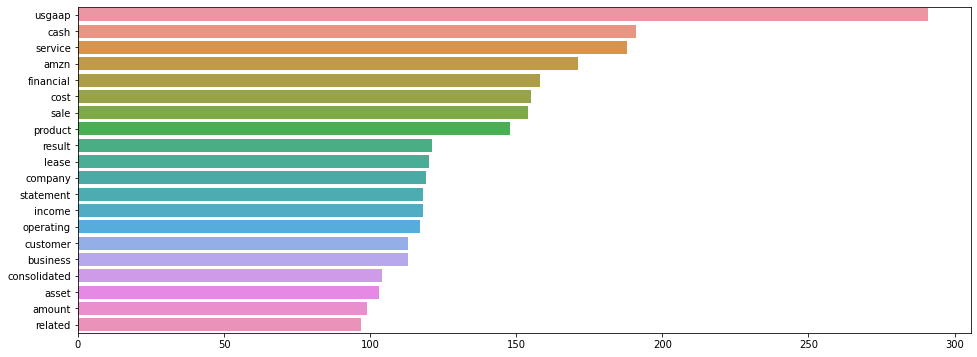

In [ ]:
counter=Counter(docs[list(docs.keys())[0]]) #first documents tokens from docs(which contains many tokens from different docs)
most=counter.most_common()

x, y=[], []
for word,count in most[:20]:
    x.append(word)
    y.append(count)

plt.figure(figsize=(16,6))    
sns.barplot(x=y,y=x)



### Price Data
Getting yearly pricing to run the factor against, since 10-Ks are produced annually.

In [49]:
pricing = pricing.pivot(index='date', columns='ticker', values='adj_close')
pricing

ticker,A,AA,AAAP,AABA,AAC,AADR,AAIT,AAL,AAMC,AAME,...,ZUMZ,ZUO,ZVZZC,ZVZZCNX,ZX,ZXYZ_A,ZYME,ZYNE,ZZK,ZZZ
date,,,,,,,,,,,,,,,,,,,,,
1962-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1963-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1964-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1965-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1966-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1967-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1968-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1969-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1970-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### Sentiment values

In [51]:
cosine_similarities_df_dict = {'date': [], 'ticker': [], 'sentiment': [], 'value': []}


for ticker, ten_k_sentiments in cosine_similarities.items():
    for sentiment_name, sentiment_values in ten_k_sentiments.items():
        for sentiment_values, sentiment_value in enumerate(sentiment_values):
            cosine_similarities_df_dict['ticker'].append(ticker)
            cosine_similarities_df_dict['sentiment'].append(sentiment_name)
            cosine_similarities_df_dict['value'].append(sentiment_value)
            cosine_similarities_df_dict['date'].append(file_dates[ticker][1:][sentiment_values])

cosine_similarities_df = pd.DataFrame(cosine_similarities_df_dict)
cosine_similarities_df['date'] = pd.DatetimeIndex(cosine_similarities_df['date']).year
cosine_similarities_df['date'] = pd.to_datetime(cosine_similarities_df['date'], format='%Y')


cosine_similarities_df.head(20)

,date,ticker,sentiment,value
0,2016-01-01,AMZN,negative,0.98087781
1,2015-01-01,AMZN,negative,0.95019843
2,2014-01-01,AMZN,negative,0.93213353
3,2013-01-01,AMZN,negative,0.89717671
4,2012-01-01,AMZN,negative,0.85849422
5,2011-01-01,AMZN,negative,0.89515146
6,2010-01-01,AMZN,negative,0.91207537
7,2009-01-01,AMZN,negative,0.90990181
8,2008-01-01,AMZN,negative,0.90364640
9,2007-01-01,AMZN,negative,0.89172750


### Constructing the similarity index dataframe for amazon

In [ ]:
cik = tick_cik_df['cik'][0]

sim_df = pd.read_csv(path_10k+"/"+cik+"/metrics/"+cik+"_sim_scores.csv")

new_columns = sim_df.columns.values
new_columns[0] = 'Dates'
sim_df.columns = new_columns
sim_df = sim_df.set_index('Dates')

sim_df = sim_df.fillna(0)

sim_df['cosine_score'] = sim_df['cosine_score'].astype(float)

sim_df['jaccard_score'] = sim_df['jaccard_score'].astype(float)

sim_df = pd.concat( [sim_df, sim_df.pct_change()] , axis = 1, sort=False)
sim_df 

,cosine_score,jaccard_score,cosine_score,jaccard_score
Dates,,,,
2001-03-23,0.000000,0.000000,NaN,NaN
2002-01-24,0.862940,0.758853,inf,inf
2003-02-19,0.864848,0.761874,0.002211,0.003981
2004-02-25,0.851950,0.741768,-0.014913,-0.026391
2005-03-11,0.861708,0.756727,0.011453,0.020167
2006-02-17,0.892635,0.806089,0.035891,0.065230
2007-02-16,0.894098,0.808454,0.001638,0.002934
2008-02-11,0.925033,0.860487,0.034600,0.064361
2009-01-30,0.912895,0.839693,-0.013122,-0.024165


## Comparing  with the real stock market situation for Amazon

In [ ]:
tickers = [tick_cik_df['ticker'][0]]

time_series =web.DataReader(tickers, "av-monthly-adjusted", start=datetime(2001, 3, 23),end=datetime(2020, 10, 31),api_key='UGBIPKZSN5NWM5LV')
time_series 

,open,high,low,close,adjusted close,volume,dividend amount
2001-03-30,9.875,14.00,9.563,10.23,10.23,167635900,0.0
2001-04-30,10.330,18.16,8.100,15.78,15.78,189780400,0.0
2001-05-31,15.900,17.60,13.100,16.69,16.69,144686700,0.0
2001-06-29,17.220,17.92,11.200,14.15,14.15,136695900,0.0
2001-07-31,14.100,17.42,11.070,12.49,12.49,172078700,0.0
...,...,...,...,...,...,...,...
2020-06-30,2448.000,2796.00,2437.130,2758.82,2758.82,87845661,0.0
2020-07-31,2757.990,3344.29,2754.000,3164.68,3164.68,127304238,0.0
2020-08-31,3180.510,3495.00,3073.000,3450.96,3450.96,83519879,0.0
2020-09-30,3489.580,3552.25,2871.000,3148.73,3148.73,115969967,0.0


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


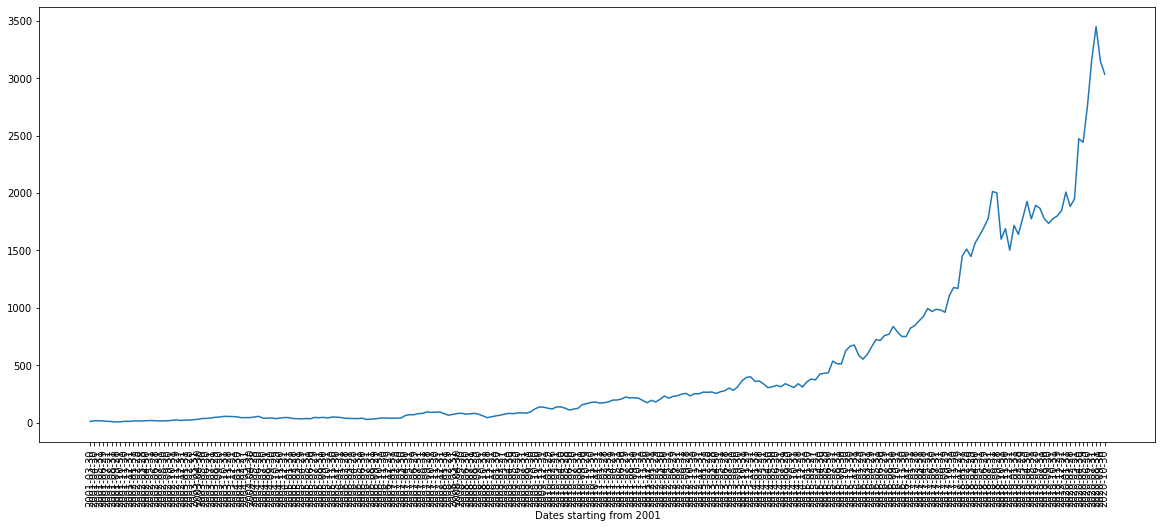

In [ ]:
x = time_series.index.values.tolist()
y = time_series['adjusted close']

# dates = [datetime.strptime(date,"%Y-%m-%d")for date in x ]
# i = 2001
# years = [i for i in range(2021)]
# plt.xticks(x,x[::12],rotation='vertical')
# plt.locator_params(axis='x', nbins=len(x)/11)

plt.figure(figsize=(20,8))
plt.xticks(rotation=90)
plt.xlabel("Dates starting from 2001")
plt.plot(x,y)
plt.show()

# Conclusion

From the above graph, we can see that the stock price of amazon has steadily increased over the span of 20 years. From the similarities score generated in the 'sim_df' dataframe, we know that the changes in the cosine similarities and jaccard similarities between the years is very low. Hence from the hypothesis we started, were we suggested 'Major text changes in 10-K over time indicate significant decreases in future returns.' can be proven true for this case. AMZN had little text changes in its 10-K documents overtime and this suggested to the steady growth of the company. 
